In [1]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
import shap
import matplotlib.pyplot as plt

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 创建新的输出目录
os.makedirs('rf_reports/figures', exist_ok=True)

# 读取处理后的数据
data = pd.read_csv('data/processed/preprocessed_dataset.csv')

# 特别注意：只在特征阶段drop date，并且稍后用SimpleImputer处理缺失
X = data.drop(columns=['date', 'tmax'])
X = X.select_dtypes(include=[np.number])
X = X.dropna(axis=1, how='all')
y = data['tmax']

# 填补X中的缺失值
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 删除y中缺失值对应的行
mask = ~y.isna()
X_imputed = X_imputed.loc[mask]
y = y.loc[mask]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# 训练Random Forest模型
print("Training Random Forest model...")
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 预测
y_pred = rf.predict(X_test)

# 模型性能
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.4f}")

Training Random Forest model...
Model Performance:
  RMSE: 0.83
  R²: 0.9310


In [3]:
# 特征重要性 (默认feature_importance)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

top_features = feature_importance.head(15)

fig = px.bar(
    top_features,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Top 15 Important Features (Random Forest)',
    labels={'Importance': 'Importance', 'Feature': 'Feature'},
    color='Importance',
    color_continuous_scale='Viridis'
)
fig.update_layout(height=600, width=900)
fig.write_html('rf_reports/figures/feature_importance.html')
fig.show()
print("✓ Created feature importance visualization")

✓ Created feature importance visualization


In [4]:
# Actual vs Predicted
fig = px.scatter(
    x=y_test,
    y=y_pred,
    title='Actual vs Predicted (Random Forest)',
    labels={'x': 'Actual tmax', 'y': 'Predicted tmax'}
)

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode='lines',
    line=dict(color='red', dash='dash'),
    showlegend=False
))

fig.write_html('rf_reports/figures/actual_vs_predicted.html')
fig.show()
print("✓ Created actual vs predicted visualization")

✓ Created actual vs predicted visualization


In [13]:
# 残差分析
residuals = y_test - y_pred
fig_residuals = px.scatter(
    x=y_pred,
    y=residuals,
    labels={'x': 'Predicted', 'y': 'Residuals'},
    title='Residual Analysis'
)
fig_residuals.add_hline(y=0, line_dash='dash', line_color='red')
fig_residuals.write_html('rf_reports/figures/residual_analysis.html')
fig_residuals.show()
print("✓ Created residual analysis visualization")

✓ Created residual analysis visualization


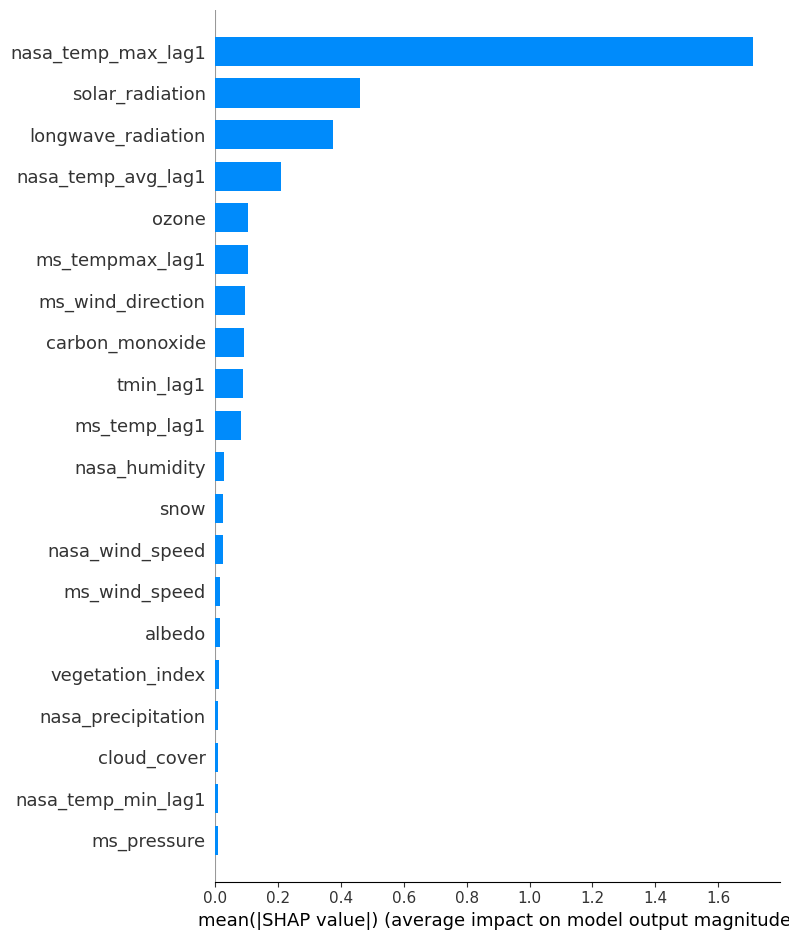

✓ Created SHAP feature importance plot


In [6]:
# SHAP解释
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('rf_reports/figures/shap_feature_importance.png', bbox_inches='tight')
plt.show()
print("✓ Created SHAP feature importance plot")

In [7]:
# 2. GridSearchCV 超参数调整
print("Tuning hyperparameters with GridSearchCV...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Tuning hyperparameters with GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [9]:
# 重新培训最佳模型
rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)

y_pred_best = rf_best.predict(X_test)

# 3. KFold 交叉验证
print("Performing K-Fold Cross-Validation...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_best, X_train, y_train, cv=kf, scoring='r2')

mean_cv_score = np.mean(cv_scores)

cv_df = pd.DataFrame({"Fold": list(range(1, 6)), "R2 Score": cv_scores})
fig_cv = px.bar(cv_df, x="Fold", y="R2 Score", title="Cross-Validation R2 Scores")
fig_cv.add_hline(y=mean_cv_score, line_dash="solid", line_color="red", 
                 annotation_text=f"Mean R2: {mean_cv_score:.4f}", annotation_position="top left")

fig_cv.write_html('rf_reports/figures/cv_scores.html')
fig_cv.show()
print("✓ Saved CV scores plot")

Performing K-Fold Cross-Validation...


✓ Saved CV scores plot


In [10]:
# 4. Bootstrap Resampling
print("Performing Bootstrap Resampling...")
def bootstrap_resampling(model, X, y, n_iterations=50, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    scores = []
    
    for _ in range(n_iterations):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_boot, y_boot = X.iloc[indices], y.iloc[indices]
        model.fit(X_boot, y_boot)
        score = model.score(X_test, y_test)
        scores.append(score)
        
    return scores

bootstrap_scores = bootstrap_resampling(rf_best, X_train, y_train)
bootstrap_df = pd.DataFrame({"R2 Score": bootstrap_scores})

# 计算均值和置信区间
mean_score = np.mean(bootstrap_scores)
lower_percentile = np.percentile(bootstrap_scores, 2.5)
upper_percentile = np.percentile(bootstrap_scores, 97.5)

fig_boot = px.histogram(bootstrap_df, x="R2 Score", nbins=20, title="Bootstrap Distribution of R2 Scores")

# 添加均值和置信区间线
fig_boot.add_vline(x=mean_score, line_color="red", line_dash="solid", 
                   annotation_text=f"Mean: {mean_score:.4f}", annotation_position="top right")
fig_boot.add_vline(x=lower_percentile, line_color="green", line_dash="dash",
                   annotation_text=f"2.5%: {lower_percentile:.4f}", annotation_position="bottom left")
fig_boot.add_vline(x=upper_percentile, line_color="green", line_dash="dash",
                   annotation_text=f"97.5%: {upper_percentile:.4f}", annotation_position="bottom right")

fig_boot.write_html('rf_reports/figures/bootstrap_distribution.html')
fig_boot.show()
print("✓ Saved bootstrap distribution plot")

Performing Bootstrap Resampling...


✓ Saved bootstrap distribution plot


Generating PDP plots for top features...


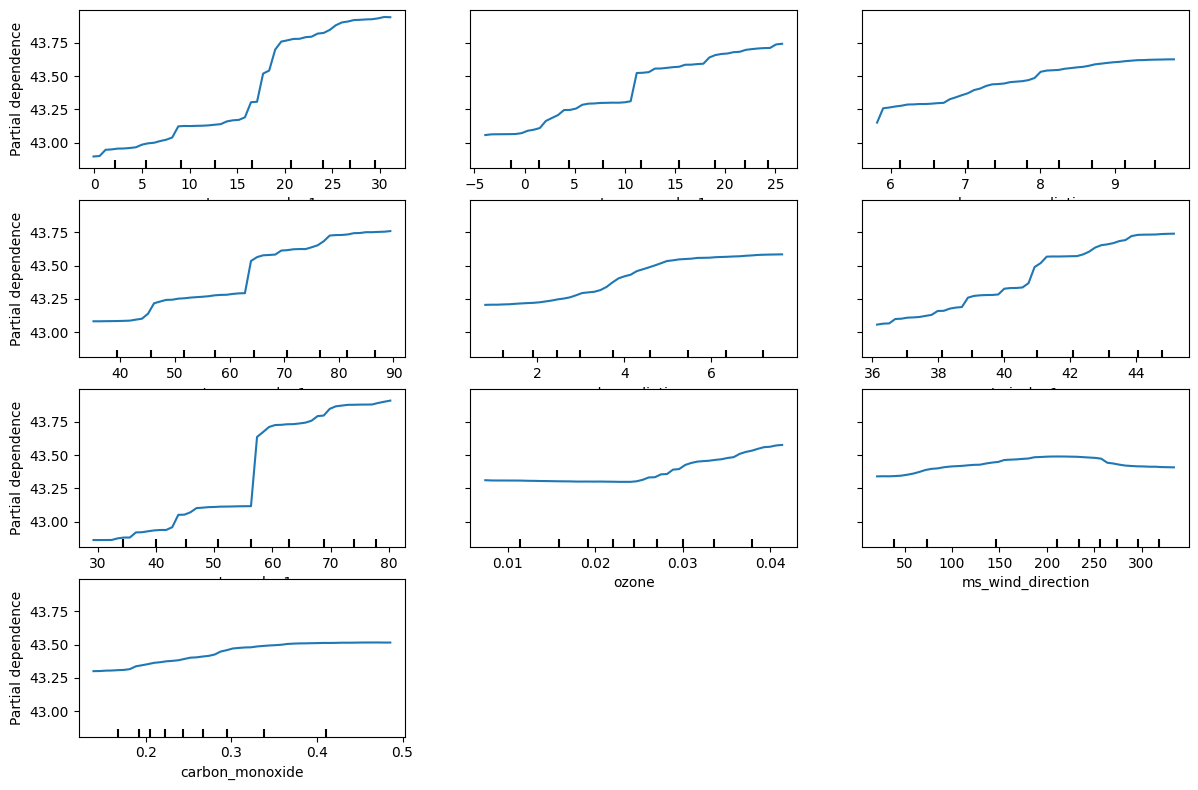

✓ Saved PDP plots (pdp_plots.png)


In [11]:
# 5. PDP (Partial Dependence Plot) 分析
from sklearn.inspection import PartialDependenceDisplay

print("Generating PDP plots for top features...")

# 选择top 3重要特征
top_features = feature_importance.sort_values('Importance', ascending=False).head(10)['Feature'].tolist()

fig_pdp, ax_pdp = plt.subplots(figsize=(12, 8))

display = PartialDependenceDisplay.from_estimator(
    rf_best,
    X_train,
    features=top_features,
    grid_resolution=50,
    ax=ax_pdp
)

plt.tight_layout()
plt.savefig('rf_reports/figures/pdp_plots.png')
plt.show()
plt.close()

print("✓ Saved PDP plots (pdp_plots.png)")



Generating ICE plots for top feature...


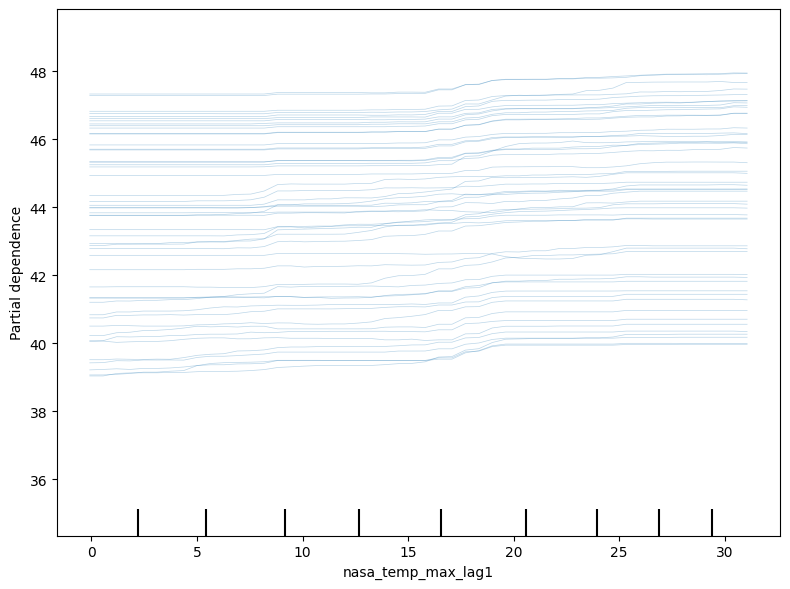

✓ Saved ICE plot for nasa_temp_max_lag1 (ice_plot.png)


In [12]:
# 6. ICE (Individual Conditional Expectation) 分析
from sklearn.inspection import PartialDependenceDisplay

print("Generating ICE plots for top feature...")

# 选取最重要的一个特征
top_feature = feature_importance.sort_values('Importance', ascending=False).iloc[0]['Feature']

fig_ice, ax_ice = plt.subplots(figsize=(8, 6))

display = PartialDependenceDisplay.from_estimator(
    rf_best,
    X_train,
    features=[top_feature],
    kind="individual",  # individual表示ICE
    subsample=50,       # 选50个样本画，防止太密
    grid_resolution=50,
    ax=ax_ice,
)

plt.tight_layout()
plt.savefig('rf_reports/figures/ice_plot.png')
plt.show()
plt.close()

print(f"✓ Saved ICE plot for {top_feature} (ice_plot.png)")
